In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
import scipy
import cv2
import os

## Convert Parquet Files into Image

In [144]:
def convert_to_images(df, label_name, feature_count):
    global benign_count, anom_count

    counter = 0
    chunk_size = feature_count * 3
    chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    output_dir = os.path.join("converted_images", str(label_name))
    os.makedirs(output_dir, exist_ok=True)

    for idx, chunk in enumerate(chunks):
        if len(chunk) != chunk_size:
            continue

        img = np.zeros((feature_count, feature_count, 3), dtype=np.uint8)

        # Process each channel (R, G, B)
        for channel in range(3):
            channel_data = chunk.iloc[channel*feature_count : (channel+1)*feature_count]
            channel_processed = np.nan_to_num(channel_data, nan=0.0, posinf=255.0, neginf=0.0)
            channel_processed = np.clip(channel_processed, 0, 255).astype(np.uint8)
            img[:, :, channel] = channel_processed

        filename = os.path.join(output_dir, f"{label_name}_{counter}.png")
        cv2.imwrite(filename, img)
        
        if label_name == 'Benign':
            benign_count += 1
        else:
            anom_count += 1
        counter += 1

In [3]:
df = pd.read_parquet(r"C:\Users\John Rome Belocora\Downloads\CIC-DDoS2019\UDP-testing.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12462 entries, 0 to 12461
Data columns (total 78 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Protocol                  12462 non-null  int8    
 1   Flow Duration             12462 non-null  int32   
 2   Total Fwd Packets         12462 non-null  int16   
 3   Total Backward Packets    12462 non-null  int16   
 4   Fwd Packets Length Total  12462 non-null  float32 
 5   Bwd Packets Length Total  12462 non-null  float32 
 6   Fwd Packet Length Max     12462 non-null  float32 
 7   Fwd Packet Length Min     12462 non-null  float32 
 8   Fwd Packet Length Mean    12462 non-null  float32 
 9   Fwd Packet Length Std     12462 non-null  float32 
 10  Bwd Packet Length Max     12462 non-null  float32 
 11  Bwd Packet Length Min     12462 non-null  float32 
 12  Bwd Packet Length Mean    12462 non-null  float32 
 13  Bwd Packet Length Std     12462 non-null  floa

In [4]:
test = pd.read_parquet(r"C:\Users\John Rome Belocora\Downloads\CIC-DDoS2019\UDP-training.parquet")
df = pd.concat([df, test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30232 entries, 0 to 17769
Data columns (total 78 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Protocol                  30232 non-null  int8   
 1   Flow Duration             30232 non-null  int32  
 2   Total Fwd Packets         30232 non-null  int16  
 3   Total Backward Packets    30232 non-null  int16  
 4   Fwd Packets Length Total  30232 non-null  float32
 5   Bwd Packets Length Total  30232 non-null  float32
 6   Fwd Packet Length Max     30232 non-null  float32
 7   Fwd Packet Length Min     30232 non-null  float32
 8   Fwd Packet Length Mean    30232 non-null  float32
 9   Fwd Packet Length Std     30232 non-null  float32
 10  Bwd Packet Length Max     30232 non-null  float32
 11  Bwd Packet Length Min     30232 non-null  float32
 12  Bwd Packet Length Mean    30232 non-null  float32
 13  Bwd Packet Length Std     30232 non-null  float32
 14  Flow Bytes/

In [146]:
benign_count = 0
anom_count = 0

In [147]:
print("Unique labels:", df['Label'].unique())

Unique labels: ['Syn' 'BENIGN']


In [148]:
print(df['Label'].value_counts())

Label
Syn       155501
BENIGN       374
Name: count, dtype: int64


In [149]:
# Prepare features and get feature count
label_col = 'Label'
features = df.drop(columns=[label_col])
feature_count = features.shape[1]

In [10]:
# Print initial counts
print(f"Initial Counts - Anomalous: {anom_count}, Benign: {benign_count}")

Initial Counts - Anomalous: 0, Benign: 0


In [11]:
# Process all labels
for label in df[label_col].unique():
    class_data = df[df[label_col] == label].drop(columns=[label_col])
    convert_to_images(class_data, label, feature_count)

print(f"Benign Images After: {benign_count}")
print(f"Anomalous Images After: {anom_count}")

Benign Images After: 0
Anomalous Images After: 674


In [13]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
print(tf.test.is_gpu_available())  

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [14]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.sysconfig.get_build_info())  # Check CUDA/cuDNN versions

True
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


## CNN Model

In [220]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r"C:\Users\John Rome Belocora\Downloads\new_converted_images"
img_size = (feature_count, feature_count) 

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)

Found 1122 images belonging to 16 classes.
Found 274 images belonging to 16 classes.


In [221]:
def create_improved_model(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(64, (3,3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.3),
        
        # Block 2
        Conv2D(128, (3,3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.4),
        
        # Block 3
        Conv2D(256, (3,3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3,3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.5),
        
        # Classifier
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [223]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

test_loss, test_acc = model.evaluate(val_generator)
print(f"Test accuracy: {test_acc:.2%}")

Epoch 1/30
9/9 [==============================] - 4s 389ms/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 0.5256 - val_accuracy: 0.9380
Epoch 2/30
9/9 [==============================] - 3s 359ms/step - loss: 0.0035 - accuracy: 0.9982 - val_loss: 0.5692 - val_accuracy: 0.9416
Epoch 3/30
9/9 [==============================] - 3s 395ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.6437 - val_accuracy: 0.9416
Epoch 4/30
9/9 [==============================] - 3s 376ms/step - loss: 0.0044 - accuracy: 0.9982 - val_loss: 0.7365 - val_accuracy: 0.9380
Epoch 5/30
9/9 [==============================] - 3s 380ms/step - loss: 0.0063 - accuracy: 0.9955 - val_loss: 0.5490 - val_accuracy: 0.9270
Epoch 6/30
9/9 [==============================] - 3s 274ms/step - loss: 0.0055 - accuracy: 0.9973 - val_loss: 0.6416 - val_accuracy: 0.9343
Epoch 7/30
9/9 [==============================] - 2s 276ms/step - loss: 0.0036 - accuracy: 0.9982 - val_loss: 0.6036 - val_accuracy: 0.9234
Epoch 8/30
9/9 [====

In [224]:
model.save('cnn_model.h5')

In [ ]:
def predict_attack_type(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[class_idx], pred[0][class_idx]

1/1 [==============================] - 0s 35ms/step


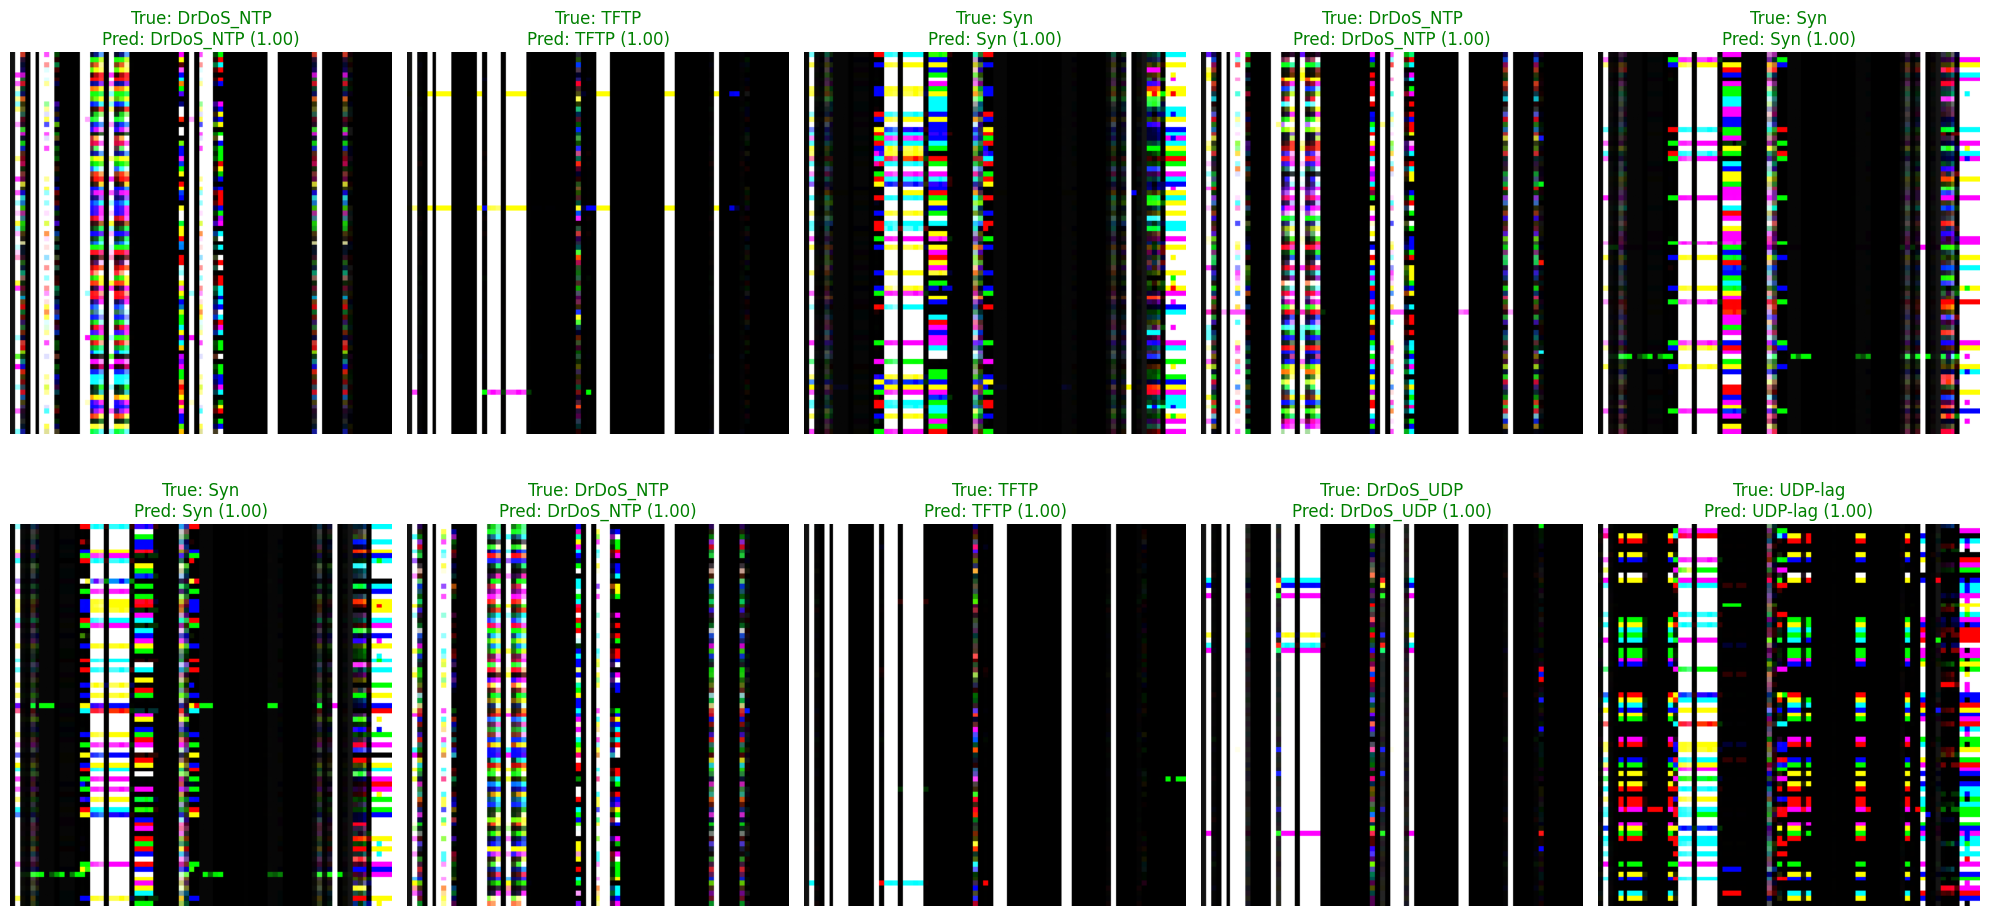

In [226]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

def visualize_predictions(test_images_dir, num_samples=10, img_size=(224, 224)):
    # Get all image files 
    image_files = []
    for root, dirs, files in os.walk(test_images_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    
    if not image_files:
        print(f"No images found in {test_images_dir}")
        return
    
    # Select random samples
    selected_images = np.random.choice(image_files, size=min(num_samples, len(image_files)), replace=False)
    
    # Create figure
    fig, axes = plt.subplots(2, (num_samples + 1) // 2, figsize=(20, 10))
    axes = axes.flat
    
    for i, img_path in enumerate(selected_images):
        if i >= len(axes):
            break
            
        try:
            # Make prediction
            true_label = os.path.basename(os.path.dirname(img_path))
            predicted_label, confidence = predict_attack_type(img_path)

            # Load and plot the image
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img) / 255.0
            axes[i].imshow(img_array)
            
            # Set title based on prediction
            color = "green" if predicted_label == true_label else "red"
            axes[i].set_title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})", color=color)
            axes[i].axis("off")
        
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            axes[i].axis("off")
            axes[i].set_title("Error loading image")
    
    plt.tight_layout()
    plt.show()

# Test the visualization
visualize_predictions(r"C:\Users\John Rome Belocora\Downloads\new_converted_images")

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

try:
    model = load_model(r"C:\Users\John Rome Belocora\Downloads\Models\cnn_model.h5", compile=False)
    # Recompile if needed
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r"C:\Users\John Rome Belocora\Downloads\new_converted_images"
img_size = (feature_count, feature_count) 

# Validation generator only 
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 274 images belonging to 16 classes.


In [ ]:
# Get the actual classes the model was trained on
model_classes = model.output_shape[-1]

# Get the validation classes
val_classes = len(val_generator.class_indices) 

# Find the intersection (classes present in both)
common_classes = sorted(list(set(val_generator.class_indices.keys()) & set(range(model_classes)))[:model_classes])

# Generate report with matching classes
print(classification_report(y_true, y_pred_classes, 
                          labels=range(model_classes),
                          target_names=[class_names[i] for i in range(model_classes)],
                          digits=4))

               precision    recall  f1-score   support

    DrDoS_DNS     1.0000    1.0000    1.0000         3
   DrDoS_LDAP     0.0000    0.0000    0.0000         1
  DrDoS_MSSQL     0.5714    0.8000    0.6667         5
    DrDoS_NTP     1.0000    1.0000    1.0000       105
DrDoS_NetBIOS     0.0000    0.0000    0.0000         0
   DrDoS_SNMP     0.3333    0.5000    0.4000         2
    DrDoS_UDP     0.6000    0.6667    0.6316         9
         LDAP     0.0000    0.0000    0.0000         1
        MSSQL     0.8333    0.7143    0.7692         7
      NetBIOS     0.0000    0.0000    0.0000         0
      Portmap     0.0000    0.0000    0.0000         0
          Syn     1.0000    1.0000    1.0000        37
         TFTP     1.0000    1.0000    1.0000        85
          UDP     0.7273    0.6667    0.6957        12
      UDP-lag     1.0000    1.0000    1.0000         7
      WebDDoS     0.0000    0.0000    0.0000         0

     accuracy                         0.9526       274
    macr

c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi